# Strain Tuning Data Analysis

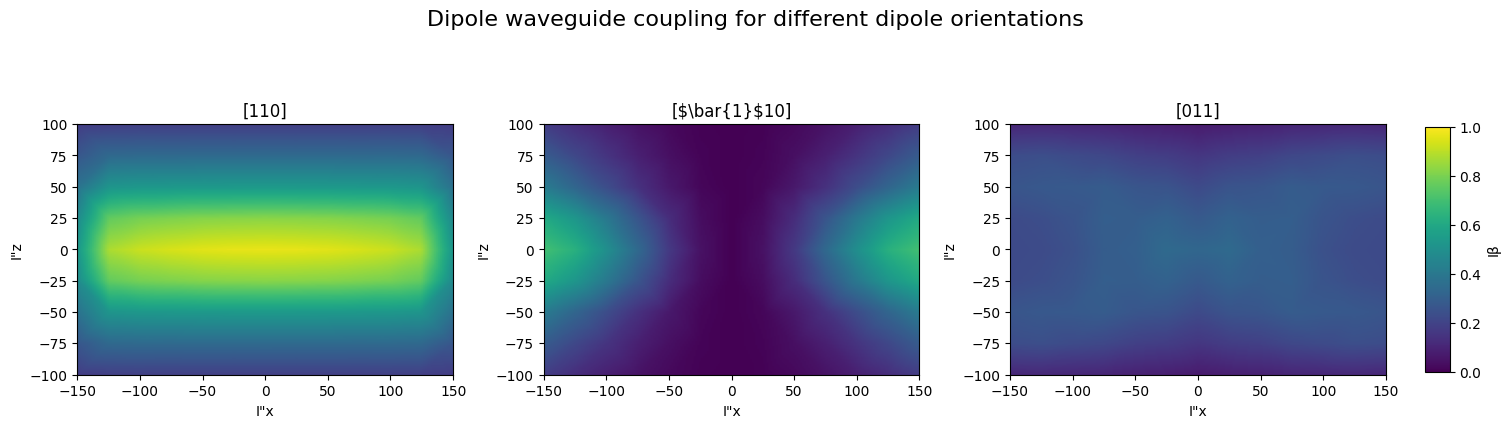

In [39]:
# Beta_factor.py (uses betaTE0.npz)
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib import colors

data = np.load('betaTE0.npz')
beta_z = data['beta_z_TE0']
beta_x = data['beta_x_TE0']
beta_y = data['beta_y_TE0']
delta_x = data['delta_x']
delta_z = data['delta_z']

Xq, Zq = np.meshgrid(delta_x, delta_z)
pts_q = np.column_stack((Xq.ravel(), Zq.ravel()))
vz_q = beta_z.T.ravel(); vx_q = beta_x.T.ravel(); vy_q = beta_y.T.ravel()

pts_all = np.vstack([
    pts_q,
    np.column_stack((-Xq.ravel(),  Zq.ravel())),
    np.column_stack(( Xq.ravel(), -Zq.ravel())),
    np.column_stack((-Xq.ravel(), -Zq.ravel())),
])
vz_all = np.concatenate([vz_q, vz_q, vz_q, vz_q])
vx_all = np.concatenate([vx_q, vx_q, vx_q, vx_q])
vy_all = np.concatenate([vy_q, vy_q, vy_q, vy_q])

x_max = float(np.max(delta_x)); z_max = float(np.max(delta_z))
x_fine = np.linspace(-x_max, x_max, 201)
z_fine = np.linspace(-z_max, z_max, 201)
Xf, Zf = np.meshgrid(x_fine, z_fine)

beta_z_interp = griddata(pts_all, vz_all, (Xf, Zf), method='linear')
beta_x_interp = griddata(pts_all, vx_all, (Xf, Zf), method='linear')
beta_y_interp = griddata(pts_all, vy_all, (Xf, Zf), method='linear')

norm = colors.Normalize(vmin=0, vmax=1)
extent = [-x_max, x_max, -z_max, z_max]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
fig.suptitle('Dipole waveguide coupling for different dipole orientations', fontsize=16, y=0.98)
im1 = axes[0].imshow(beta_x_interp, origin='lower', extent=extent, cmap='viridis', norm=norm, aspect='equal')
axes[0].set_title('[110]'); axes[0].set_xlabel('I\"x'); axes[0].set_ylabel('I\"z')
im2 = axes[1].imshow(beta_y_interp, origin='lower', extent=extent, cmap='viridis', norm=norm, aspect='equal')
axes[1].set_title(r'[\$\bar{1}\$10]'); axes[1].set_xlabel('I\"x'); axes[1].set_ylabel('I\"z')
im3 = axes[2].imshow(beta_z_interp, origin='lower', extent=extent, cmap='viridis', norm=norm, aspect='equal')
axes[2].set_title('[011]'); axes[2].set_xlabel('I\"x'); axes[2].set_ylabel('I\"z')
cbar = fig.colorbar(im3, ax=axes, location='right', pad=0.02, shrink=0.5, aspect=10)
cbar.set_label('Iβ')
plt.show()


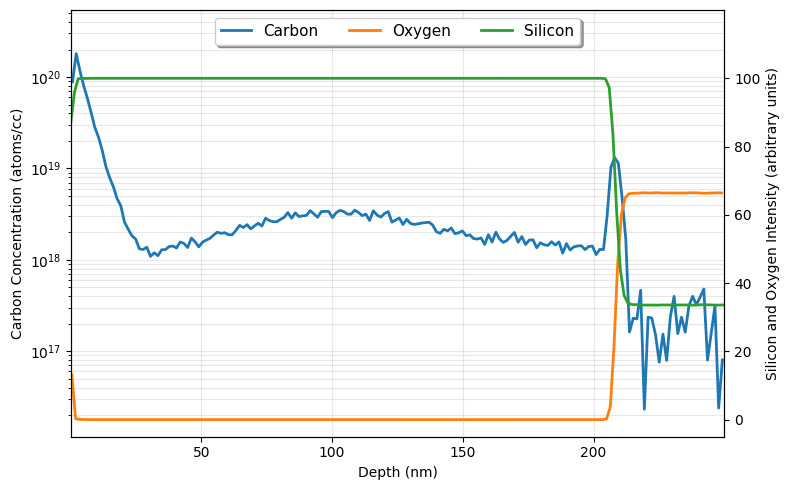

In [40]:
# Concentration.py (from Concentration_processed.npz)
import numpy as np
import matplotlib.pyplot as plt
d = np.load('Concentration_processed.npz', allow_pickle=True)
depth_C, conc_C = d['depth_C'], d['conc_C']
depth_O, conc_O = d['depth_O'], d['conc_O']
depth_Si, conc_Si = d['depth_Si'], d['conc_Si']
fig, ax = plt.subplots(figsize=(8, 5))
line_c, = ax.plot(depth_C, conc_C, color='#1f77b4', linewidth=2, label='Carbon')
ax.set_yscale('log'); ax.set_xlabel('Depth (nm)'); ax.set_ylabel('Carbon Concentration (atoms/cc)')
lines=[line_c]; labels=['Carbon']; ax2=ax.twinx()
if depth_O.size and conc_O.size:
    line_o, = ax2.plot(depth_O, conc_O, color='#ff7f0e', linewidth=2, label='Oxygen'); lines.append(line_o); labels.append('Oxygen')
if depth_Si.size and conc_Si.size:
    line_si, = ax2.plot(depth_Si, conc_Si, color='#2ca02c', linewidth=2, label='Silicon'); lines.append(line_si); labels.append('Silicon')
ax2.set_ylabel('Silicon and Oxygen Intensity (arbitrary units)')
xmin=np.inf; xmax=-np.inf
for arr in [depth_C, depth_O, depth_Si]:
    if arr.size:
        xmin=min(xmin, np.min(arr)); xmax=max(xmax, np.max(arr))
if np.isfinite(xmin) and np.isfinite(xmax): ax.set_xlim(xmin, xmax)
if depth_C.size and conc_C.size:
    c_pos=conc_C[conc_C>0]
    if c_pos.size: ax.set_ylim(np.min(c_pos)*0.5, np.max(conc_C)*3)
y2_max_values = [np.max(a) for a in [conc_O, conc_Si] if a.size]
y2_max = max(y2_max_values) if y2_max_values else 0
if y2_max>0: ax2.set_ylim(-5, y2_max*1.2)
ax.grid(True, which='both', alpha=0.3); ax.legend(lines, labels, loc='upper center', frameon=True, fontsize=11, fancybox=True, shadow=True, ncol=3)
plt.tight_layout(); plt.show()


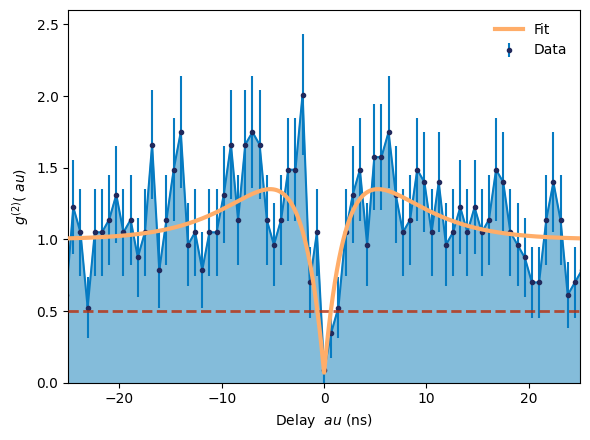

In [41]:
# g2.py (from solo_rider_first_g2.npz)
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import Model
from scipy.interpolate import interp1d
COLOR_DATA = '#21295C'; COLOR_ERROR = '#067BC2'; COLOR_INTERP = '#067BC2'; COLOR_FIT = '#FFAD69'; COLOR_FILL = '#84BCDA'; COLOR_REF = '#BA2D0B'
def g2_blinking(x, amp, a, Gamma1, b, Gamma2, t0):
    return amp - (1 - a) * ((1 + b) * np.exp(-np.abs(x - t0)/Gamma1) - b * np.exp(-np.abs(x - t0)/Gamma2))
d = np.load('solo_rider_first_g2.npz'); corr_delay = d['corr_delay']
binwidth=0.7e-9; edges_ps=np.arange(-200e-9, 200e-9+binwidth, binwidth)*1e12; centers_ps=edges_ps[1:] - binwidth*1e12/2
counts,_=np.histogram(corr_delay, bins=edges_ps); errors=np.sqrt(counts)
norm=np.mean(counts[:50]); y=counts/norm; err=errors/norm
min_delay_ps=centers_ps[np.argmin(counts)]; x_ns=(centers_ps - min_delay_ps)*1e-3
mask=(x_ns>=-30)&(x_ns<=30); x_fit,y_fit,err_fit=x_ns[mask],y[mask],err[mask]
mod=Model(g2_blinking); pars=mod.make_params(amp=1,a=0.1,Gamma1=2,b=2,Gamma2=8,t0=0); pars['amp'].set(vary=False); pars['t0'].set(vary=False)
result=mod.fit(y_fit, params=pars, x=x_fit, weights=1/np.clip(err_fit,1e-9,None))
x_smooth=np.linspace(-30,30,2001); y_smooth=mod.eval(params=result.params, x=x_smooth)
f_lin=interp1d(x_fit,y_fit,kind='linear',bounds_error=False,fill_value='extrapolate'); x_lin=np.linspace(x_fit.min(),x_fit.max(),2001); y_lin=f_lin(x_lin)
fig, ax = plt.subplots(figsize=(6.0,4.5))
ax.errorbar(x_fit,y_fit,yerr=err_fit,fmt='o',ms=3,lw=1.5,color=COLOR_DATA,ecolor=COLOR_ERROR,capsize=0,label='Data')
ax.plot(x_lin,y_lin,'-',lw=1.5,color=COLOR_INTERP,alpha=1); ax.fill_between(x_lin,0,y_lin,color=COLOR_FILL,alpha=1)
ax.plot(x_smooth,y_smooth,'-',color=COLOR_FIT,lw=3,label='Fit',zorder=10); ax.axhline(0.5,color=COLOR_REF,linestyle='--',linewidth=2,alpha=0.8,zorder=9)
ax.set_xlim(-25,25); ax.set_ylim(0,2.6); ax.set_xlabel('Delay $\	au$ (ns)'); ax.set_ylabel('$g^{(2)}(\	au)$'); ax.legend(frameon=False, loc='upper right'); plt.tight_layout(); plt.show()


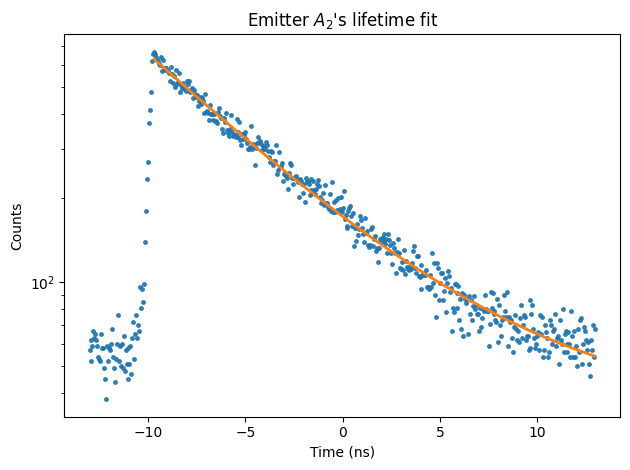

In [42]:
# Lifetime.py (from lifetime_sL20_us_.npz)
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model, Parameters
def exp_decay(t, t0, tau, A, B):
    t = np.asarray(t, dtype=float); y = np.where(t >= t0, A * np.exp(-(t - t0) / tau), 0.0); return y + B
d = np.load('lifetime_sL20_us_.npz'); time=d['time'].astype(float); counts=d['counts'].astype(float)
i_peak=int(np.argmax(counts)); t0=float(time[i_peak]); tail_start=int(0.85*len(counts)); B0=float(np.median(counts[max(0,tail_start):])); A0=max(float(counts[i_peak]-B0),1.0)
dt=np.median(np.diff(time)); tail_mask=(time>t0+3*dt)&(counts>B0*1.05); tau0=10.0
if tail_mask.sum()>=8:
    y=np.clip(counts[tail_mask]-B0,1.0,None); x=time[tail_mask]; m,_=np.polyfit(x-t0,np.log(y),1);
    if m<0: tau0=float(np.clip(-1.0/m,0.05,1e4))
start_idx=min(i_peak, len(time)-1); mask=time>=time[start_idx]; t_fit=time[mask]; c_fit=counts[mask]
model=Model(exp_decay); pars=Parameters(); pars.add('t0',value=t0,vary=False); pars.add('tau',value=tau0,min=0.02,max=1e4); pars.add('A',value=A0,min=0.0); pars.add('B',value=B0,min=0.0)
sigma=np.sqrt(np.clip(c_fit,1.0,None)); weights=1.0/sigma; result=model.fit(c_fit, params=pars, t=t_fit, weights=weights)
t_fine=np.linspace(time.min(),time.max(),2000); y_fit=exp_decay(t_fine, result.params['t0'].value, result.params['tau'].value, result.params['A'].value, result.params['B'].value)
fig, ax = plt.subplots(); ax.semilogy(time,counts,'.',ms=5,alpha=0.9); ax.semilogy(t_fine[t_fine>=t0], y_fit[t_fine>=t0], '-', lw=2); ax.set_title("Emitter $A_2$'s lifetime fit"); ax.set_xlabel('Time (ns)'); ax.set_ylabel('Counts'); plt.tight_layout(); plt.show()


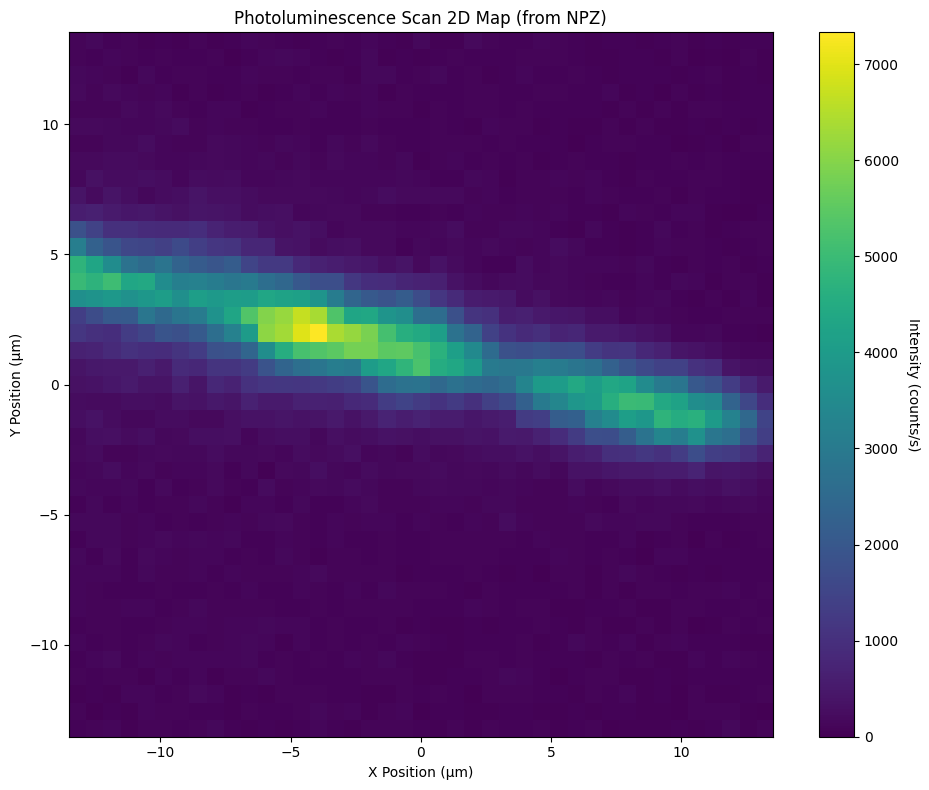

In [43]:
# PL_scan.py (already NPZ)
import numpy as np
import matplotlib.pyplot as plt
d=np.load('PL_scan.npz'); x=d['x']; y=d['y']; counts=d['counts']
fig, ax = plt.subplots(figsize=(10,8)); im=ax.imshow(counts, cmap='viridis', aspect='equal', origin='lower', extent=[x.min(),x.max(), y.min(), y.max()]); cbar=plt.colorbar(im, ax=ax); cbar.set_label('Intensity (counts/s)', rotation=270, labelpad=15); ax.set_xlabel('X Position (μm)'); ax.set_ylabel('Y Position (μm)'); ax.set_title('Photoluminescence Scan 2D Map (from NPZ)'); plt.tight_layout(); plt.show()


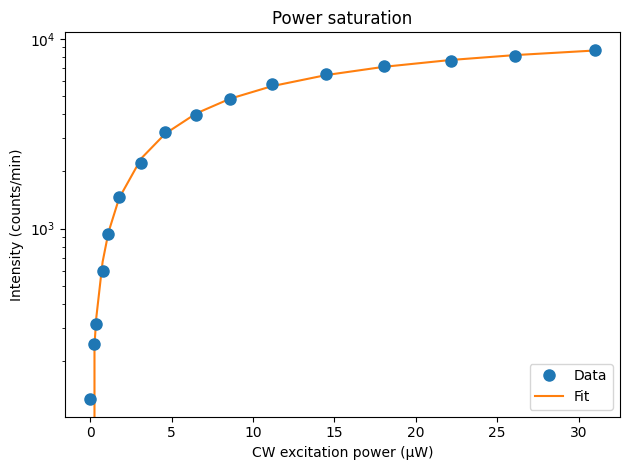

In [44]:
# Saturation_curve.py (already NPZ)
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import Model
WL_MIN, WL_MAX = 1275.0, 1279.0; BG_CONST = 60.0; FIT_SLICE = slice(4,-1)
def pwr_saturation_lin(x, Iinf, Psat): return Iinf * (1.0 / (1.0 + Psat / x))
d=np.load('Saturation_spectrometer_B.npz'); wl=d['wavelength']; counts=d['counts']; powers=d['power_in']
m=(wl>WL_MIN)&(wl<WL_MAX); wl_fit=wl[m]; Y=counts[:,m]-BG_CONST; nP,nL=Y.shape; int_1=np.zeros(nP,float)
for k in range(nP): c=int(np.argmax(Y[k,:])); a=c-4; b=c+4; int_1[k]=np.sum(Y[k,a:b])
P=powers*5.0; mod=Model(pwr_saturation_lin); pars=mod.make_params(); pars['Psat'].set(value=20,vary=True,min=0,max=float(np.max(P*1e6))); pars['Iinf'].set(value=float(np.max(int_1)), vary=True); result=mod.fit(int_1[FIT_SLICE], params=pars, x=P[FIT_SLICE]*1e6)
plt.figure(); xfit=P[FIT_SLICE]*1e6; yfit=int_1[FIT_SLICE]; plt.semilogy(xfit,yfit,'o',ms=8,label='Data'); plt.semilogy(xfit,result.best_fit,lw=1.5,label='Fit',zorder=0); plt.legend(loc='lower right'); plt.xlabel('CW excitation power (μW)'); plt.ylabel('Intensity (counts/min)'); plt.title('Power saturation'); plt.tight_layout(); plt.show()


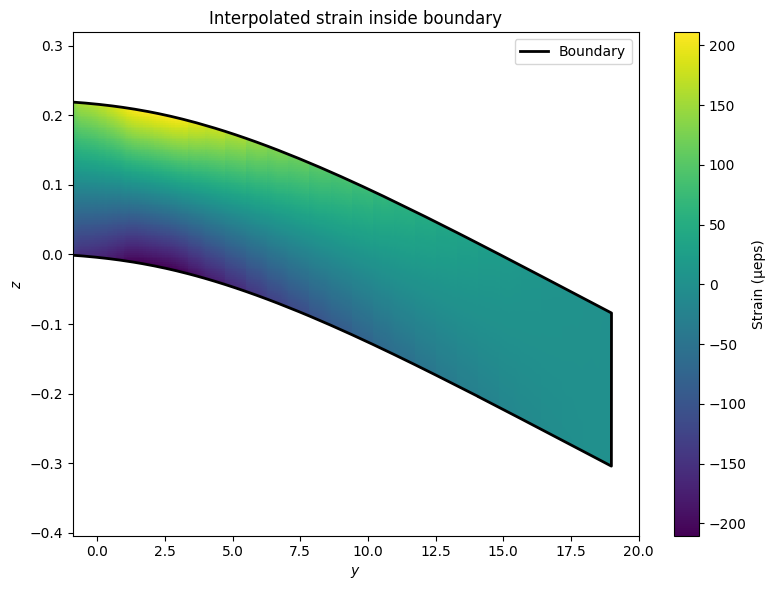

In [45]:
# Strain_map.py (from NPZ)
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.path import Path
d=np.load('Strain_larger_35V_241124.npz'); y,z,strain_yy=d['y'],d['z'],d['strain_yy']
mask=(y>-1)&(z>-1); y_filt,y_filt_z,strain_filt=y[mask],z[mask],strain_yy[mask]
def pareto_front(y, z, minimize_y=True, minimize_z=True):
    yy = y if minimize_y else -y; zz = z if minimize_z else -z; order=np.lexsort((zz,yy)); yy_s,zz_s=yy[order],zz[order]; pareto_mask=np.ones(len(yy_s),bool); best_zz=np.inf
    for i,val in enumerate(zz_s):
        if val<best_zz: best_zz=val
        else: pareto_mask[i]=False
    return order[pareto_mask]
idx_upper=pareto_front(y_filt,y_filt_z,False,False); yu,zu=y_filt[idx_upper],y_filt_z[idx_upper]; u_order=np.argsort(yu); yu,zu=yu[u_order],zu[u_order]
idx_lower=pareto_front(y_filt,y_filt_z,True,True); yl,zl=y_filt[idx_lower],y_filt_z[idx_lower]; l_order=np.argsort(yl); yl,zl=yl[l_order],zl[l_order]
ymin_val=float(np.min(y_filt)); ymax_val=float(np.max(y_filt))
import numpy as _np
ymin_pts=_np.column_stack((y_filt[_np.isclose(y_filt,ymin_val)], y_filt_z[_np.isclose(y_filt,ymin_val)]))
ymax_pts=_np.column_stack((y_filt[_np.isclose(y_filt,ymax_val)], y_filt_z[_np.isclose(y_filt,ymax_val)]))
ymin_bottom=ymin_pts[_np.argmin(ymin_pts[:,1])]; ymin_top=ymin_pts[_np.argmax(ymin_pts[:,1])]
ymax_bottom=ymax_pts[_np.argmin(ymax_pts[:,1])]; ymax_top=ymax_pts[_np.argmax(ymax_pts[:,1])]
boundary_y=[]; boundary_z=[]
boundary_y.append(float(ymin_bottom[0])); boundary_z.append(float(ymin_bottom[1]))
boundary_y.extend(list(yl)); boundary_z.extend(list(zl))
boundary_y.append(float(ymax_bottom[0])); boundary_z.append(float(ymax_bottom[1]))
boundary_y.append(float(ymax_top[0])); boundary_z.append(float(ymax_top[1]))
boundary_y.extend(list(yu[::-1])); boundary_z.extend(list(zu[::-1]))
boundary_y.append(float(ymin_top[0])); boundary_z.append(float(ymin_top[1]))
polygon=_np.column_stack((boundary_y,boundary_z)); poly_path=Path(polygon)
Ny,Nz=1000,200; yg=_np.linspace(min(boundary_y),max(boundary_y),Ny); zg=_np.linspace(min(boundary_z),max(boundary_z),Nz); Yg,Zg=_np.meshgrid(yg,zg)
points=_np.column_stack((y_filt,y_filt_z)); values=strain_filt; strain_grid=griddata(points,values,(Yg,Zg),method='linear')
mask_inside=poly_path.contains_points(_np.column_stack((Yg.ravel(),Zg.ravel()))).reshape(Yg.shape); strain_grid[~mask_inside]=_np.nan
plt.figure(figsize=(8,6)); plt.pcolormesh(Yg,Zg,strain_grid*1e6,shading='auto',cmap='viridis'); plt.colorbar(label='Strain (μeps)'); plt.plot(boundary_y,boundary_z,'k-',lw=2,label='Boundary'); plt.xlabel('$y$'); plt.ylabel('$z$'); plt.title('Interpolated strain inside boundary'); plt.legend(); plt.xlim(-0.9,20); plt.ylim(min(boundary_z)-0.1,max(boundary_z)+0.1); plt.tight_layout(); plt.show()


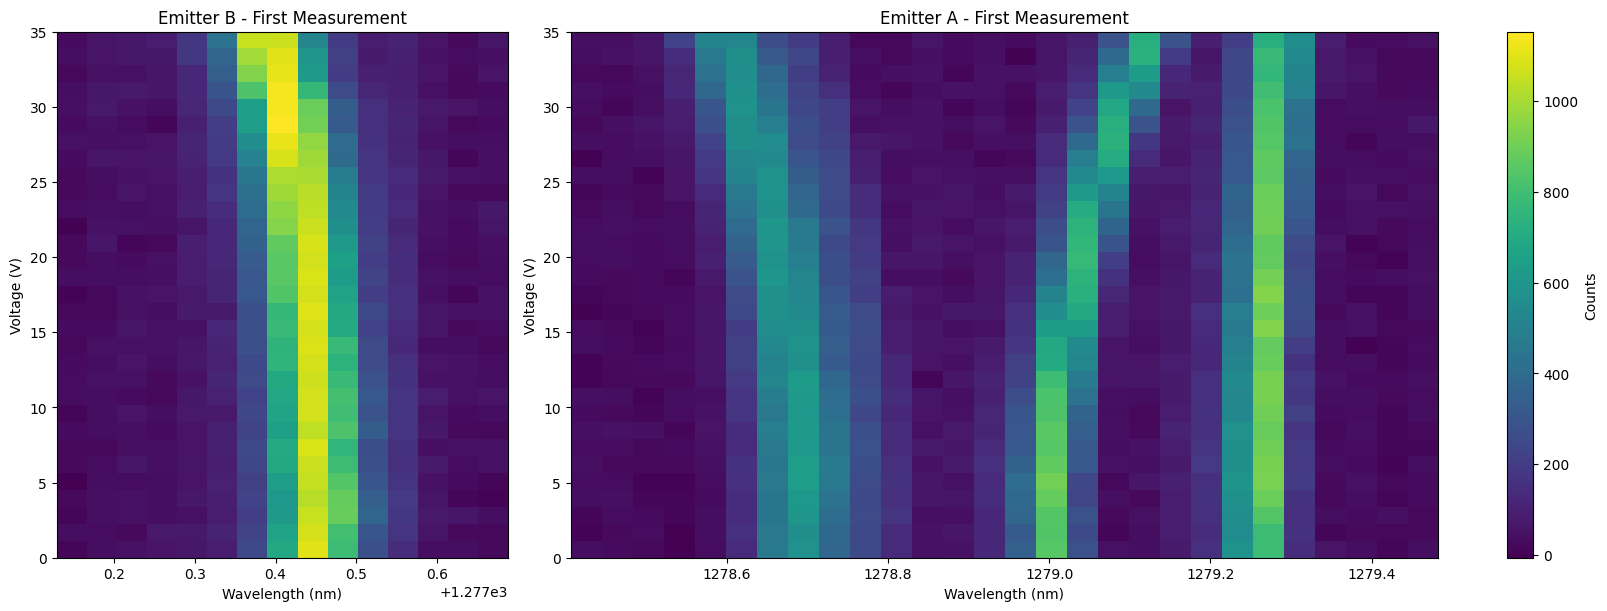

In [46]:
# Tuning_emitters.py (already NPZ)
import numpy as np
import matplotlib.pyplot as plt
data_a=np.load('Tuning_emitter_A.npz'); data_b=np.load('Tuning_emitter_B.npz')
wavelength_a, voltage_a, counts_a = data_a['wavelength'], data_a['v_meas'], data_a['counts']
wavelength_b, voltage_b, counts_b = data_b['wavelength'], data_b['v_meas'], data_b['counts']
ZOOM_A=(1278.4,1279.5); ZOOM_B=(1277.1,1277.7)
mask_a=(wavelength_a>=ZOOM_A[0])&(wavelength_a<=ZOOM_A[1]); mask_b=(wavelength_b>=ZOOM_B[0])&(wavelength_b<=ZOOM_B[1])
wz_a=wavelength_a[mask_a]; wz_b=wavelength_b[mask_b]; cz_a=counts_a[:,mask_a]; cz_b=counts_b[:,mask_b]
xr_a=float(np.ptp(wz_a)); xr_b=float(np.ptp(wz_b))
vmin_all=min(float(voltage_a.min()), float(voltage_b.min())); vmax_all=max(float(voltage_a.max()), float(voltage_b.max()))
cmin=float(min(np.nanmin(cz_a), np.nanmin(cz_b))); cmax=float(max(np.nanmax(cz_a), np.nanmax(cz_b)))
fig, axes = plt.subplots(1,2, figsize=(16,6), constrained_layout=True, gridspec_kw={'width_ratios':[xr_b,xr_a]})
im1=axes[0].imshow(cz_b, origin='lower', aspect='auto', extent=[wz_b.min(),wz_b.max(), voltage_b.min(), voltage_b.max()], vmin=cmin, vmax=cmax, cmap='viridis')
axes[0].set_title('Emitter B - First Measurement'); axes[0].set_xlabel('Wavelength (nm)'); axes[0].set_ylabel('Voltage (V)'); axes[0].set_ylim(vmin_all, vmax_all)
im2=axes[1].imshow(cz_a, origin='lower', aspect='auto', extent=[wz_a.min(),wz_a.max(), voltage_a.min(), voltage_a.max()], vmin=cmin, vmax=cmax, cmap='viridis')
axes[1].set_title('Emitter A - First Measurement'); axes[1].set_xlabel('Wavelength (nm)'); axes[1].set_ylabel('Voltage (V)'); axes[1].set_ylim(vmin_all, vmax_all)
cbar=fig.colorbar(im2, ax=axes.ravel().tolist()); cbar.set_label('Counts'); plt.show()
